## Similitud Cosenos (Matriz de Similitud)

Archivos similares: 0b27be88.java y 3f4a5b64.java, Similaridad: 1.0
Archivos similares: 2a655afe.java y 692a4496.java, Similaridad: 1.0000000000000002
Archivos similares: 3e6def38.java y 548ffb07.java, Similaridad: 0.9749745710875758
Archivos similares: 5449d33c.java y 86102d81.java, Similaridad: 0.7437654185756679


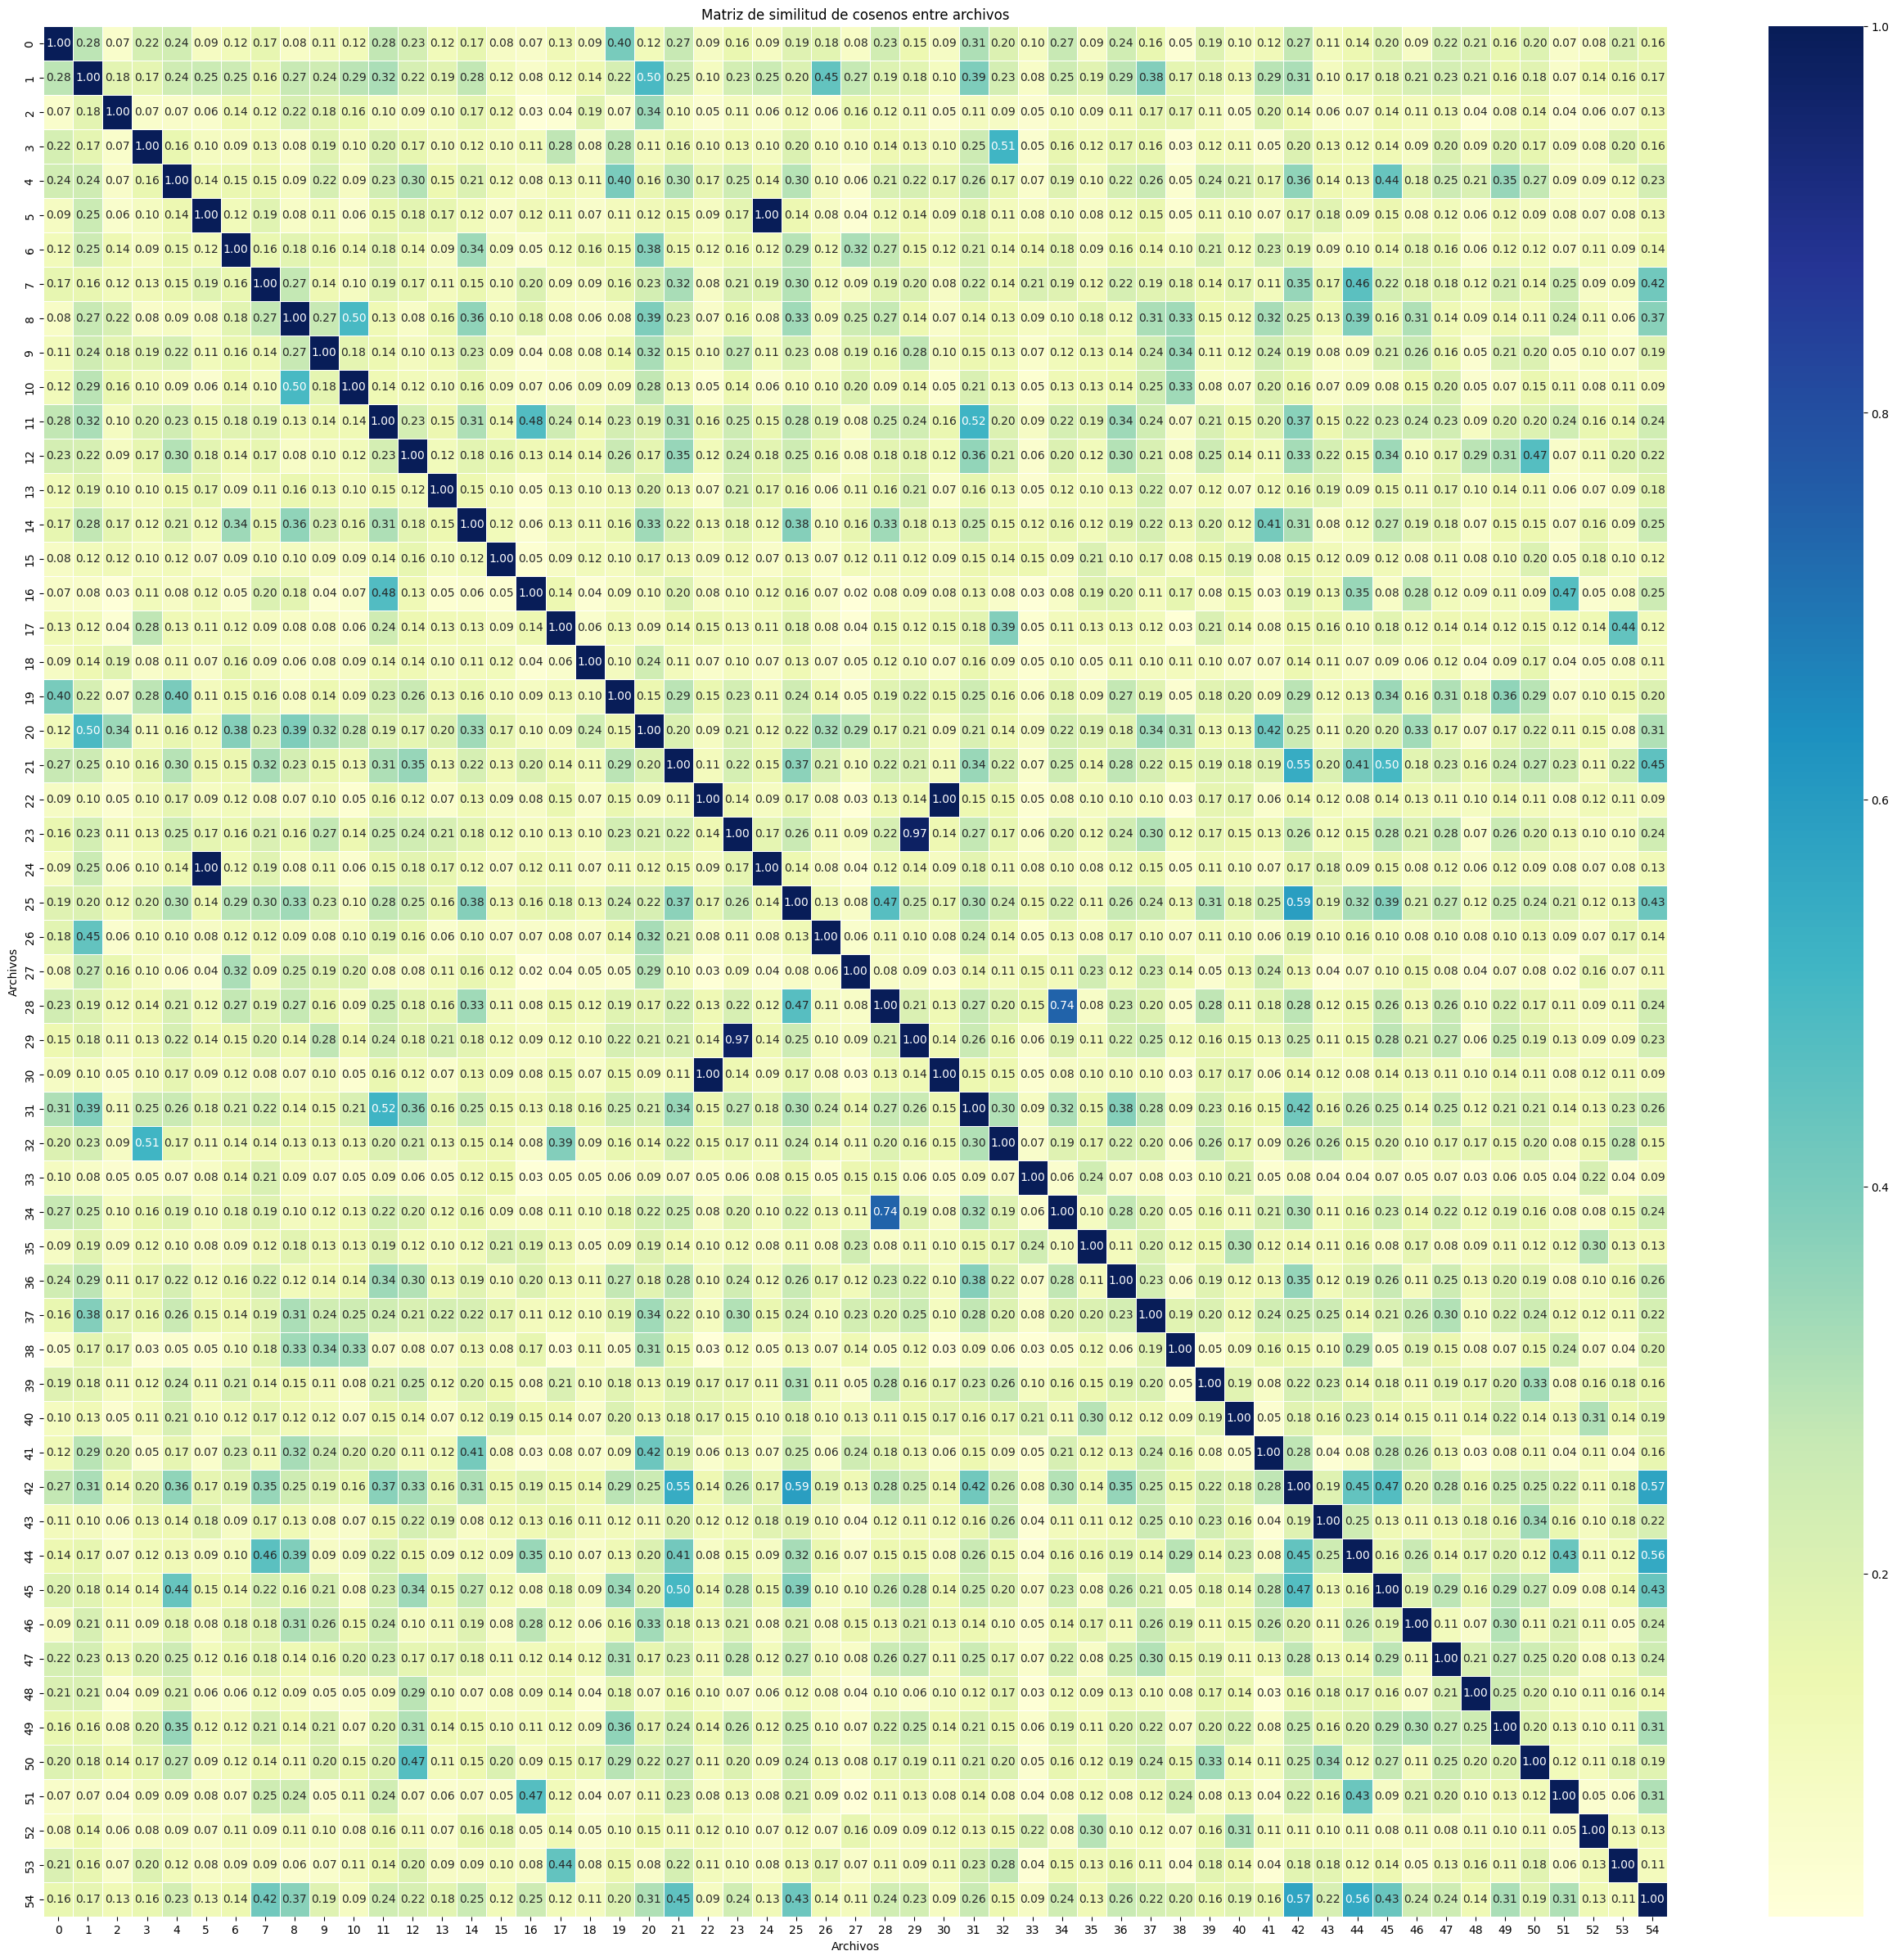

In [14]:
import os
import javalang
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def limpiar_archivo_java(archivo):
    with open(archivo, 'r') as file:
        contenido = file.read()

    # Eliminar sangría y saltos de línea
    contenido = re.sub(r'\n\s*', '\n', contenido)

    # Eliminar comentarios de una línea
    contenido = re.sub(r'//.*', '', contenido)

    # Eliminar comentarios de múltiples líneas
    contenido = re.sub(r'/\*(.|\n)*?\*/', '', contenido)

    # Eliminar líneas de importación de bibliotecas
    contenido = re.sub(r'import\s+.*?;', '', contenido)

    # Eliminar líneas en blanco adicionales
    contenido = re.sub(r'\n\s*\n', '\n', contenido)

    return contenido

def generate_file_contents(folder_path):
    file_contents = {}
    files = [file for file in os.listdir(folder_path) if file.endswith('.java')]

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        cleaned_content = limpiar_archivo_java(file_path)
        file_contents[file_name] = cleaned_content

    return file_contents

def calculate_cosine_similarity(file_contents):
    # Convertir los contenidos de los archivos a una lista
    corpus = list(file_contents.values())

    # Utilizar TfidfVectorizer para obtener las características de los archivos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Calcular la matriz de similitud de cosenos entre los archivos
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return similarity_matrix

# Directorio que contiene los archivos Java
folder_path = ".\\conplag\\programs"

# Obtener los contenidos de los archivos
file_contents = generate_file_contents(folder_path)

# Calcular la similitud de cosenos entre los archivos
similarity_matrix = calculate_cosine_similarity(file_contents)

# Obtener los nombres de los archivos
file_names = list(file_contents.keys())

# Iterar sobre la matriz de similitud de cosenos y encontrar pares de archivos similares
for i in range(len(file_names)):
    for j in range(i + 1, len(file_names)):
        if similarity_matrix[i, j] > 0.65:
            print(f"Archivos similares: {file_names[i]} y {file_names[j]}, Similaridad: {similarity_matrix[i, j]}")


# print(similarity_matrix)
plt.figure(figsize=(32, 30))
heatmap = sns.heatmap(similarity_matrix, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title("Matriz de similitud de cosenos entre archivos")
plt.xlabel("Archivos")
plt.ylabel("Archivos")
plt.show()

## Similitud Cosenos (ASTs)

In [2]:
from scipy.spatial.distance import cosine
import numpy as np
import os
import re
import javalang


def limpiar_archivo_java(archivo):
    with open(archivo, 'r') as file:
        contenido = file.read()

    # Eliminar sangría y saltos de línea
    contenido = re.sub(r'\n\s*', '\n', contenido)

    # # Eliminar comentarios de una línea
    # contenido = re.sub(r'//.*', '', contenido)

    # # Eliminar comentarios de múltiples líneas
    # contenido = re.sub(r'/\*(.|\n)*?\*/', '', contenido)

    # Eliminar líneas de importación de bibliotecas
    contenido = re.sub(r'import\s+.*?;', '', contenido)

    # Eliminar líneas en blanco adicionales
    contenido = re.sub(r'\n\s*\n', '\n', contenido)

    return contenido


carpeta = ".\\conplag\\programs"
archivos_java = [archivo for archivo in os.listdir(
    carpeta) if archivo.endswith('.java')]

ast_trees = {}

for archivo in archivos_java:
    ruta_archivo = os.path.join(carpeta, archivo)
    contenido_limpio = limpiar_archivo_java(ruta_archivo)
    tokens = javalang.tokenizer.tokenize(contenido_limpio)

    try:
        parser = javalang.parser.Parser(tokens)
        ast_tree = parser.parse_member_declaration()
        # Guardar el AST en un diccionario con el nombre del archivo como clave
        ast_trees[archivo] = ast_tree
    except javalang.parser.JavaSyntaxError as e:
        print("Error de sintaxis en", archivo, ":", e)

In [3]:
print(ast_trees)

{'00af3420.java': ClassDeclaration(annotations=[], body=[MethodDeclaration(annotations=[], body=[LocalVariableDeclaration(annotations=[], declarators=[VariableDeclarator(dimensions=[], initializer=ClassCreator(arguments=[MemberReference(member=in, postfix_operators=[], prefix_operators=[], qualifier=System, selectors=[])], body=None, constructor_type_arguments=None, postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], type=ReferenceType(arguments=None, dimensions=None, name=Scanner, sub_type=None)), name=sc)], modifiers=set(), type=ReferenceType(arguments=None, dimensions=[], name=Scanner, sub_type=None)), LocalVariableDeclaration(annotations=[], declarators=[VariableDeclarator(dimensions=[], initializer=ClassCreator(arguments=[MemberReference(member=out, postfix_operators=[], prefix_operators=[], qualifier=System, selectors=[])], body=None, constructor_type_arguments=None, postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], type=ReferenceType(a

## Conteo de tipos de datos totales

In [4]:
def contar_tipos_de_datos(ast_trees):
    tipos_de_datos = {}

    for archivo, ast_tree in ast_trees.items():
        # Recorrer el árbol sintáctico abstracto
        for _, node in ast_tree:
            # Obtener el tipo de nodo
            tipo = type(node).__name__
            # Incrementar el contador para este tipo de dato
            tipos_de_datos[tipo] = tipos_de_datos.get(tipo, 0) + 1

    return tipos_de_datos

# Obtener el conteo de tipos de datos
conteo_tipos_de_datos = contar_tipos_de_datos(ast_trees)

# Mostrar los resultados
for tipo, conteo in conteo_tipos_de_datos.items():
    print(f"{tipo}: {conteo}")

ClassDeclaration: 68
MethodDeclaration: 140
FormalParameter: 182
ReferenceType: 628
LocalVariableDeclaration: 585
VariableDeclarator: 951
ClassCreator: 204
MemberReference: 3460
BasicType: 970
MethodInvocation: 989
WhileStatement: 62
BinaryOperation: 1308
Literal: 1356
BlockStatement: 433
ArrayCreator: 111
ForStatement: 246
ForControl: 238
VariableDeclaration: 245
StatementExpression: 865
Assignment: 448
ArraySelector: 699
TypeArgument: 75
IfStatement: 178
BreakStatement: 23
FieldDeclaration: 90
ReturnStatement: 67
EnhancedForControl: 8
ConstructorDeclaration: 6
ThrowStatement: 4
Cast: 53
ContinueStatement: 9
ArrayInitializer: 5
TernaryExpression: 11
This: 6


In [5]:
def contar_tipos_de_datos_por_archivo(ast_trees):
    conteo_por_archivo = {}

    for archivo, ast_tree in ast_trees.items():
        conteo_tipos_de_datos = {}
        # Recorrer el árbol sintáctico abstracto
        for _, node in ast_tree:
            # Obtener el tipo de nodo
            tipo = type(node).__name__
            # Incrementar el contador para este tipo de dato
            conteo_tipos_de_datos[tipo] = conteo_tipos_de_datos.get(tipo, 0) + 1

        # Guardar el conteo para este archivo
        conteo_por_archivo[archivo] = conteo_tipos_de_datos

    return conteo_por_archivo

# Obtener el conteo de tipos de datos por archivo
conteo_tipos_de_datos_por_archivo = contar_tipos_de_datos_por_archivo(ast_trees)

# Mostrar los resultados
for archivo, conteo_tipos in conteo_tipos_de_datos_por_archivo.items():
    print(f"Archivo: {archivo}")
    for tipo, conteo in conteo_tipos.items():
        print(f"\t{tipo}: {conteo}")


Archivo: 00af3420.java
	ClassDeclaration: 1
	MethodDeclaration: 1
	FormalParameter: 1
	ReferenceType: 10
	LocalVariableDeclaration: 12
	VariableDeclarator: 16
	ClassCreator: 3
	MemberReference: 34
	BasicType: 12
	MethodInvocation: 13
	WhileStatement: 2
	BinaryOperation: 9
	Literal: 12
	BlockStatement: 7
	ArrayCreator: 1
	ForStatement: 4
	ForControl: 4
	VariableDeclaration: 4
	StatementExpression: 9
	Assignment: 3
	ArraySelector: 3
	TypeArgument: 1
	IfStatement: 2
	BreakStatement: 1
Archivo: 00c0b82a.java
	ClassDeclaration: 1
	MethodDeclaration: 1
	FormalParameter: 1
	ReferenceType: 3
	LocalVariableDeclaration: 9
	VariableDeclarator: 17
	ClassCreator: 1
	MemberReference: 60
	BasicType: 20
	MethodInvocation: 10
	ForStatement: 8
	ForControl: 8
	VariableDeclaration: 8
	Literal: 21
	BinaryOperation: 16
	BlockStatement: 8
	ArrayCreator: 4
	StatementExpression: 10
	Assignment: 8
	ArraySelector: 16
Archivo: 00db6701.java
	ClassDeclaration: 1
	MethodDeclaration: 1
	FormalParameter: 1
	Reference

In [17]:
import numpy as np

# Obtener las claves únicas de los tipos de datos
tipos_de_datos_unicos = set()
for conteo_tipos in conteo_tipos_de_datos_por_archivo.values():
    tipos_de_datos_unicos.update(conteo_tipos.keys())

# Ordenar los tipos de datos únicos alfabéticamente
tipos_de_datos_unicos = sorted(tipos_de_datos_unicos)

# Crear una matriz para almacenar los conteos
matriz_conteos = np.zeros((len(conteo_tipos_de_datos_por_archivo), len(tipos_de_datos_unicos)), dtype=int)

# Llenar la matriz con los conteos
for i, (archivo, conteo_tipos) in enumerate(conteo_tipos_de_datos_por_archivo.items()):
    for j, tipo_dato in enumerate(tipos_de_datos_unicos):
        matriz_conteos[i, j] = conteo_tipos.get(tipo_dato, 0)

# Mostrar la matriz
print("Matriz de conteos:")
print(matriz_conteos)


Matriz de conteos:
[[ 1  0  3 ...  4 16  2]
 [ 4  0 16 ...  8 17  0]
 [ 0  0  8 ...  0 11  1]
 ...
 [ 2  0 10 ...  4 11  0]
 [ 0  0  3 ...  3 13  1]
 [ 3  1  6 ...  4 12  1]]


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud de coseno entre cada par de archivos
similar_pairs = []
threshold = 0.98  # Umbral de similitud

for i in range(len(matriz_conteos)):
    for j in range(i + 1, len(matriz_conteos)):
        similarity = cosine_similarity([matriz_conteos[i]], [matriz_conteos[j]])[0][0]
        if similarity >= threshold:
            similar_pairs.append((i, j, similarity))

# Mostrar los pares similares encontrados
if similar_pairs:
    print("Pares de archivos con similitud igual o mayor al 0.98:")
    for pair in similar_pairs:
        archivo1 = list(conteo_tipos_de_datos_por_archivo.keys())[pair[0]]
        archivo2 = list(conteo_tipos_de_datos_por_archivo.keys())[pair[1]]
        similarity = pair[2]
        print(f"Archivos: {archivo1} y {archivo2}, Similitud: {similarity}")
else:
    print("No se encontraron pares de archivos con similitud igual o mayor al 0.98.")


Pares de archivos con similitud igual o mayor al 0.98:
Archivos: 00af3420.java y 0c9d4def.java, Similitud: 0.9816725302388823
Archivos: 00af3420.java y 0df4050e.java, Similitud: 0.9904867857421914
Archivos: 00af3420.java y 1a6f8b20.java, Similitud: 0.9875581424094692
Archivos: 00af3420.java y 5449d33c.java, Similitud: 0.9848017797764567
Archivos: 00af3420.java y 6f02c6d9.java, Similitud: 0.9827411902419737
Archivos: 00af3420.java y 86102d81.java, Similitud: 0.9801914596556983
Archivos: 00af3420.java y 9291ca83.java, Similitud: 0.9821402580621253
Archivos: 00af3420.java y 97a7fab5.java, Similitud: 0.9900306215708773
Archivos: 00af3420.java y ce0b2178.java, Similitud: 0.9806511106522996
Archivos: 00af3420.java y d92c5342.java, Similitud: 0.9888521610668941
Archivos: 00af3420.java y f665e87b.java, Similitud: 0.9883098965811613
Archivos: 00c0b82a.java y 0b04b41e.java, Similitud: 0.9801420688853556
Archivos: 00c0b82a.java y 11c2ab99.java, Similitud: 0.9851035885777258
Archivos: 00c0b82a.jav

In [ ]:
def matriz_normalizada_columnas(matriz):
    # Calcular la suma de cada columna
    suma_columnas = np.sum(matriz, axis=0)
    
    # Dividir cada elemento de la columna por su suma
    matriz_normalizada = matriz / suma_columnas[np.newaxis, :]
    
    return matriz_normalizada

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud de cosenos entre las filas de la matriz de conteos
similitud_cos = cosine_similarity(matriz_normalizada_columnas)

# Mostrar la matriz de similitud de cosenos
print("Matriz de similitud de cosenos:")
print(similitud_cos)


Matriz de similitud de cosenos:
[[1.         0.61093919 0.70286199 ... 0.53611518 0.89624066 0.19180549]
 [0.61093919 1.         0.63344983 ... 0.51739009 0.36881475 0.23119917]
 [0.70286199 0.63344983 1.         ... 0.44995685 0.46755542 0.18999074]
 ...
 [0.53611518 0.51739009 0.44995685 ... 1.         0.46814651 0.14054183]
 [0.89624066 0.36881475 0.46755542 ... 0.46814651 1.         0.11553476]
 [0.19180549 0.23119917 0.18999074 ... 0.14054183 0.11553476 1.        ]]


In [8]:
import pandas as pd

# Obtener los nombres de los archivos
nombres_archivos = list(conteo_tipos_de_datos_por_archivo.keys())

# Crear un DataFrame con la matriz de similitud de cosenos
df_similitud_cos = pd.DataFrame(similitud_cos, index=nombres_archivos, columns=nombres_archivos)

# Mostrar el DataFrame
print("Matriz de similitud de cosenos:")
print(df_similitud_cos)


Matriz de similitud de cosenos:
               00af3420.java  00c0b82a.java  00db6701.java  00f79486.java  \
00af3420.java       1.000000       0.610939       0.702862       0.521691   
00c0b82a.java       0.610939       1.000000       0.633450       0.352644   
00db6701.java       0.702862       0.633450       1.000000       0.562147   
00f79486.java       0.521691       0.352644       0.562147       1.000000   
0b04b41e.java       0.507190       0.418725       0.398365       0.413857   
0b27be88.java       0.183359       0.130305       0.189886       0.254302   
0b5cff5a.java       0.735674       0.895741       0.865410       0.520952   
0b91922c.java       0.712427       0.564785       0.743818       0.792817   
0c00d532.java       0.236054       0.251339       0.313434       0.198120   
0c0af0ff.java       0.552667       0.711476       0.706709       0.773794   
0c1143f7.java       0.734532       0.798619       0.947879       0.524516   
0c173033.java       0.645133       0.808433 

In [9]:
# Definir el umbral de similitud
umbral_similitud = 0.95

# Filtrar los pares de archivos con similitud mayor o igual al umbral
pares_similitud_alta = df_similitud_cos[df_similitud_cos >= umbral_similitud].stack().reset_index()
pares_similitud_alta.columns = ['Archivo 1', 'Archivo 2', 'Similitud']

# Filtrar los pares de archivos que no son el mismo archivo
pares_similitud_alta = pares_similitud_alta[pares_similitud_alta['Archivo 1'] != pares_similitud_alta['Archivo 2']]

# Mostrar los pares de archivos con similitud alta
print("Archivos similares:")
archivos_mostrados = set()  # Conjunto para almacenar los pares de archivos ya mostrados
for _, row in pares_similitud_alta.iterrows():
    archivo1 = row['Archivo 1']
    archivo2 = row['Archivo 2']
    similitud = row['Similitud']
    # Verificar si el par de archivos ya ha sido mostrado
    if (archivo1, archivo2) not in archivos_mostrados and (archivo2, archivo1) not in archivos_mostrados:
        print(f"{archivo1} - {archivo2}: Similitud = {round(similitud, 4)}")
        archivos_mostrados.add((archivo1, archivo2))

Archivos similares:
0b27be88.java - 3f4a5b64.java: Similitud = 1.0
0c173033.java - 6b83b22e.java: Similitud = 0.9532
0cedec8a.java - ac8acb97.java: Similitud = 0.9824
2a655afe.java - 692a4496.java: Similitud = 1.0
3e6def38.java - 548ffb07.java: Similitud = 0.9969
6f02c6d9.java - fb312dc6.java: Similitud = 0.9525
c4ca2ff3.java - d92c5342.java: Similitud = 0.9664


## Comparación convirtiendo archivos a texto y utilizando TF-IDF con Similitud de Coseno

In [43]:
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Función para preprocesar el código Java
def preprocesar_codigo(archivo):
    with open(archivo, "r", encoding="utf-8") as f:
        codigo = f.read()

    # Eliminar comentarios (// y /* */)
    codigo = re.sub(r'//.*?\n', '', codigo)
    codigo = re.sub(r'/\*.*?\*/', '', codigo, flags=re.DOTALL)

    # Eliminar saltos de línea e imports
    codigo = re.sub(r'[\n\t]', ' ', codigo)
    codigo = re.sub(r'import\s+.*?;', '', codigo)

    return codigo

# Directorio que contiene los archivos .java
directorio = ".\\conplag\\programs"

# Diccionario para almacenar el código preprocesado
codigo_preprocesado = {}

# Leer cada archivo .java en el directorio y preprocesar el código
for archivo in os.listdir(directorio):
    if archivo.endswith(".java"):
        ruta_completa = os.path.join(directorio, archivo)
        codigo = preprocesar_codigo(ruta_completa)
        codigo_preprocesado[archivo] = codigo

# Vectorizar los textos utilizando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(codigo_preprocesado.values())

# Calcular la similitud de coseno entre cada par de archivos
similitudes = cosine_similarity(X)

# Conjunto para almacenar pares de archivos ya mostrados
mostrados = set()

# Imprimir la similitud entre cada par de archivos
for i, archivo1 in enumerate(codigo_preprocesado.keys()):
    for j, archivo2 in enumerate(codigo_preprocesado.keys()):
        if i < j:
            similitud = similitudes[i, j]
            if similitud >= 0.7 and (archivo1, archivo2) not in mostrados and (archivo2, archivo1) not in mostrados:
                print(f"Similitud de coseno entre {archivo1} y {archivo2}: {round(similitud, 2)}")
                mostrados.add((archivo1, archivo2))


Similitud de coseno entre 0b27be88.java y 3f4a5b64.java: 1.0
Similitud de coseno entre 2a655afe.java y 692a4496.java: 1.0
Similitud de coseno entre 3e6def38.java y 548ffb07.java: 0.97
Similitud de coseno entre 5449d33c.java y 86102d81.java: 0.74
